['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Kuttervirus', '/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Tequintavirus', '/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Cheoctovirus', '/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Skunavirus', '/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Epseptimavirus']
/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Kuttervirus
/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Tequintavirus
/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Cheoctovirus
/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Skunavirus
/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Epseptimavirus


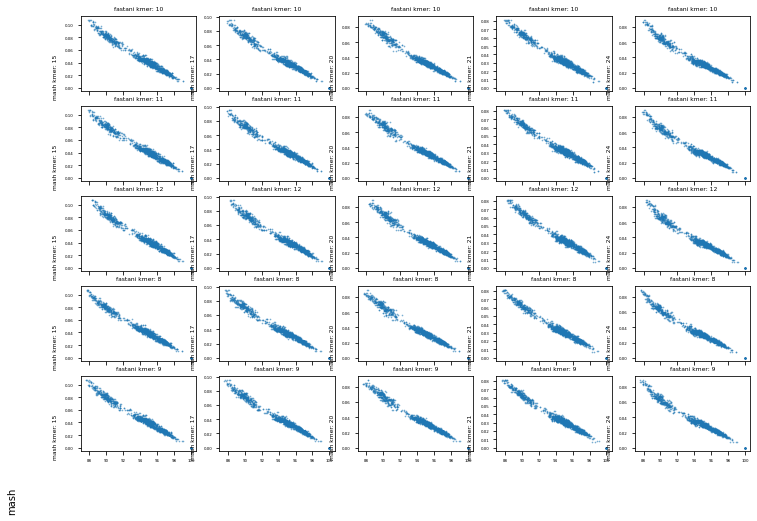

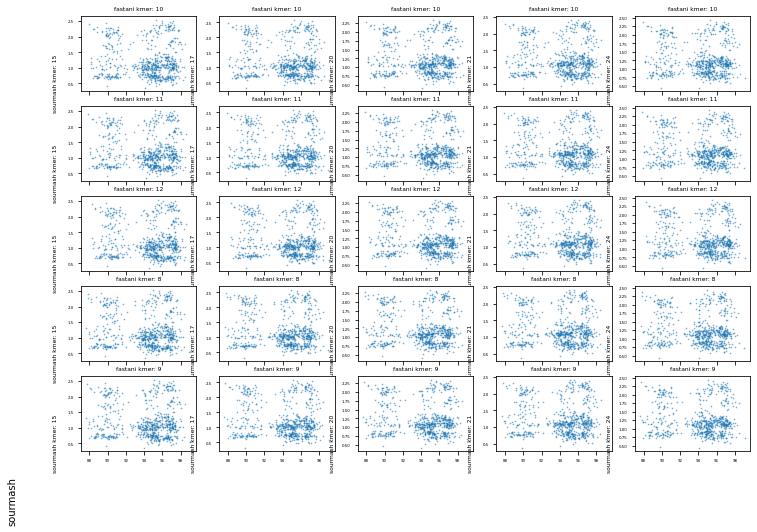

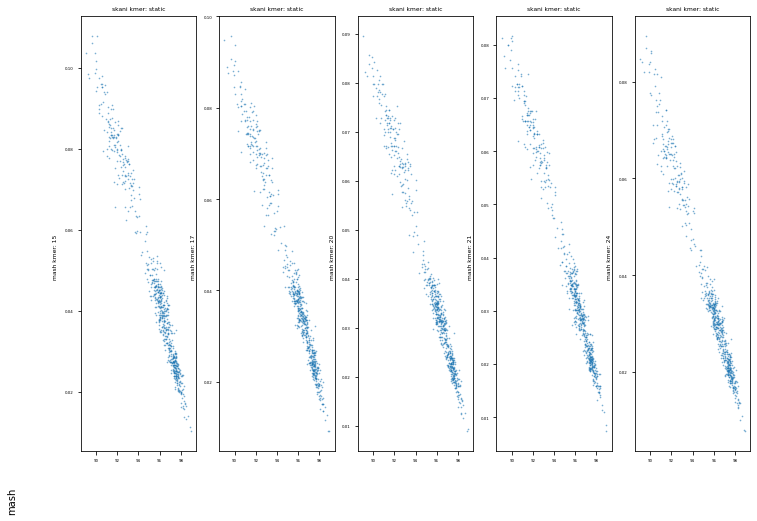

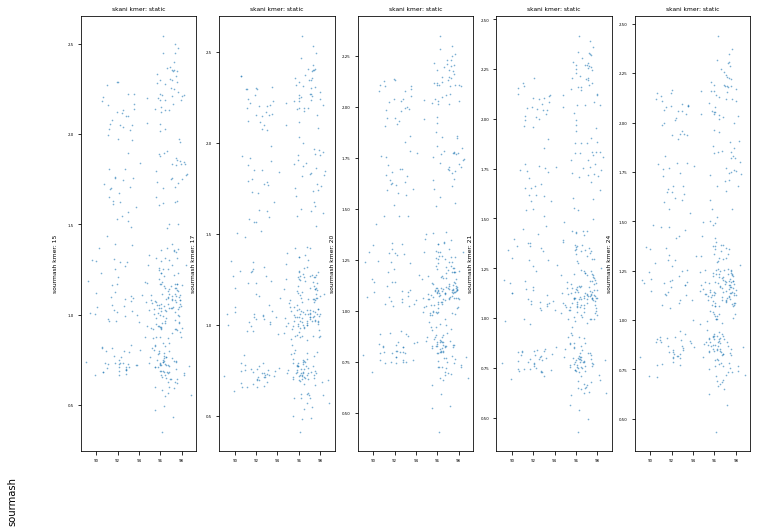

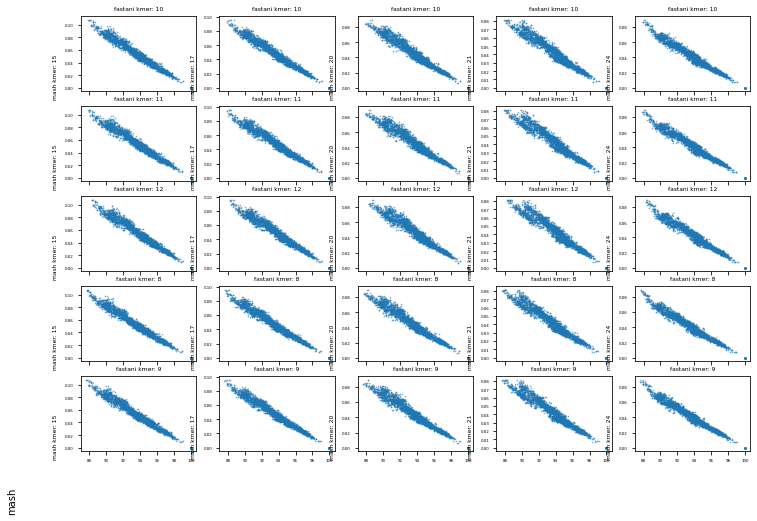

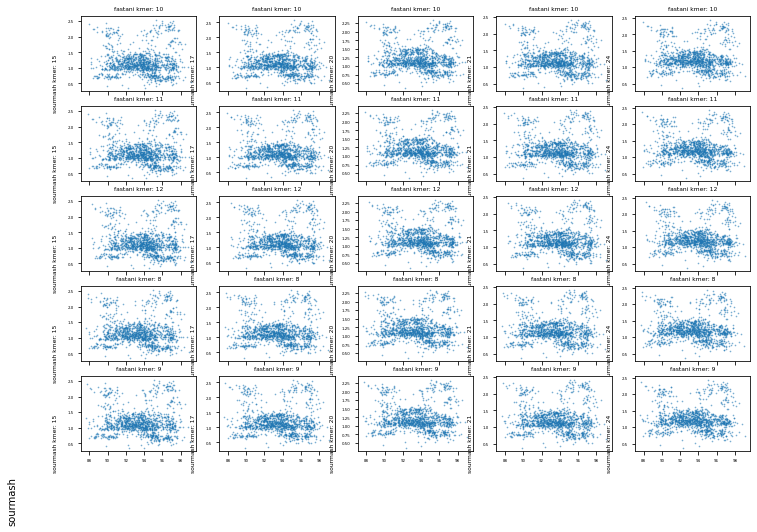

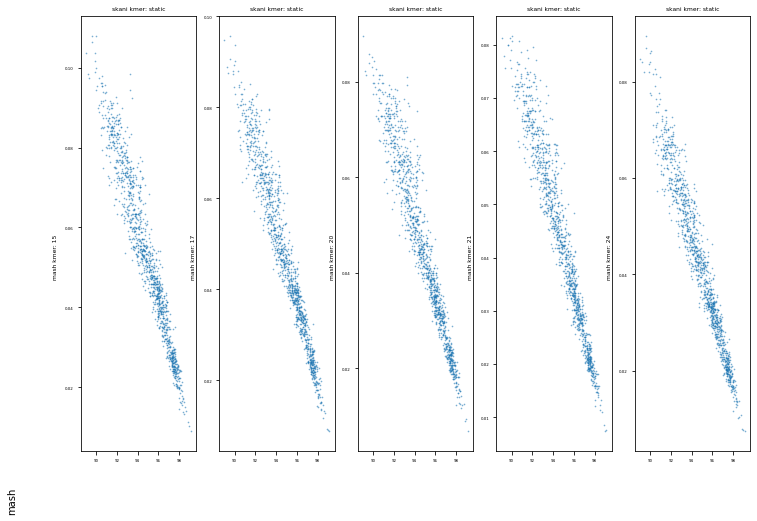

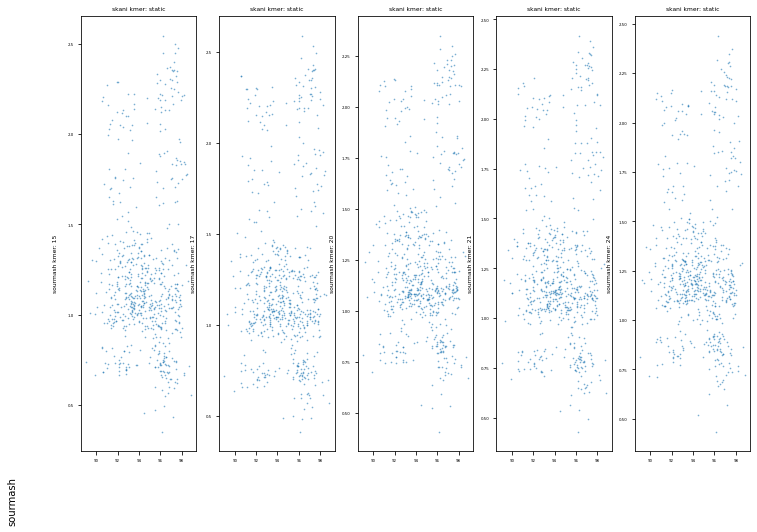

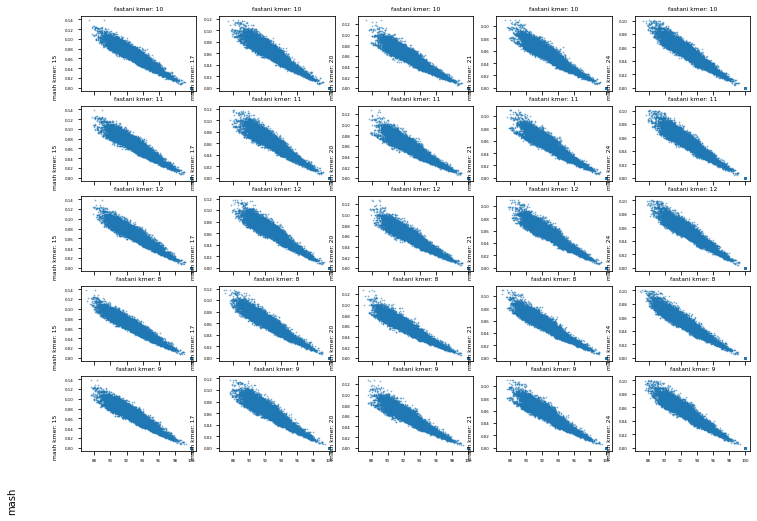

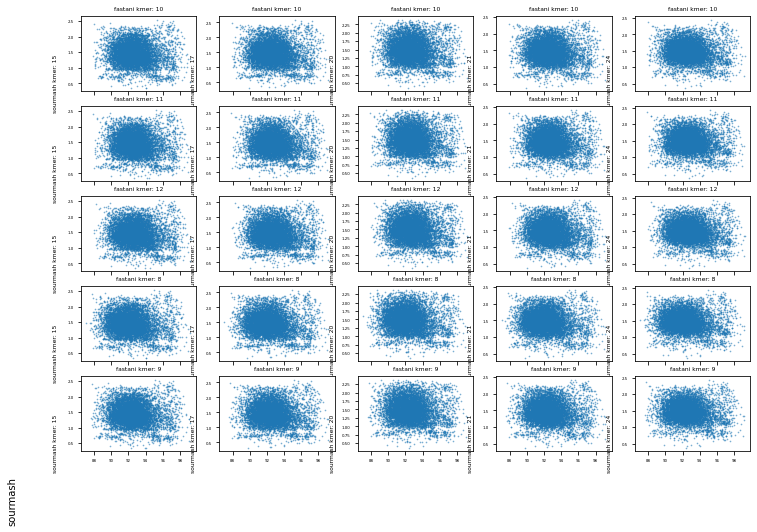

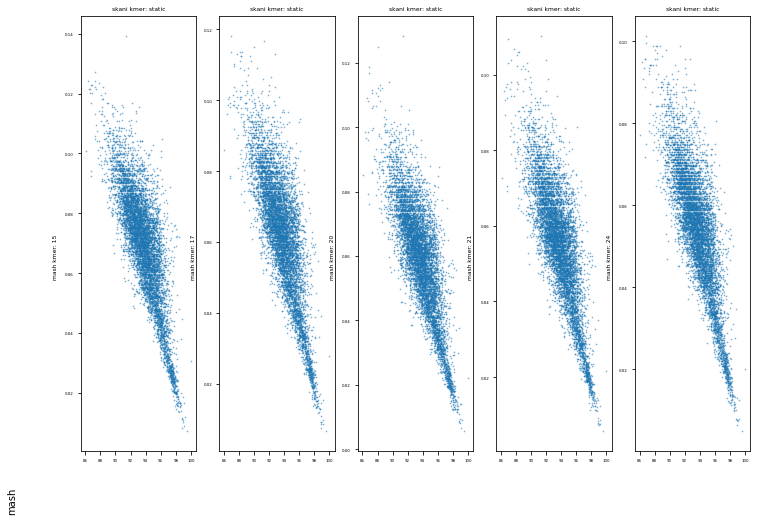

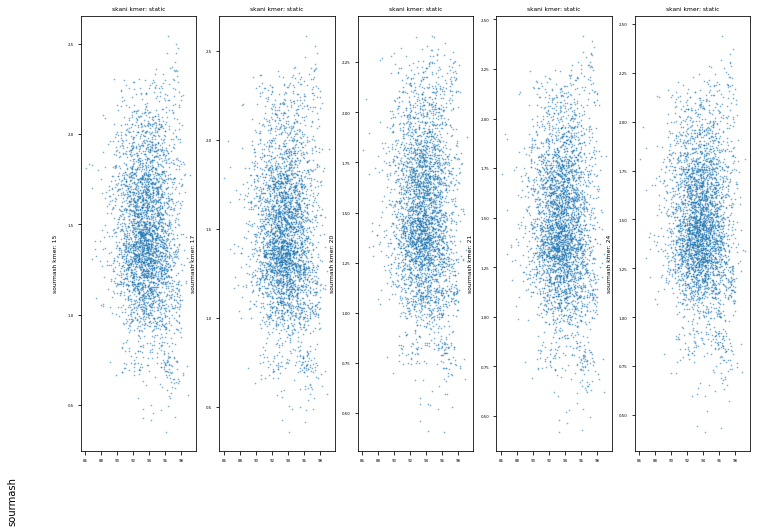

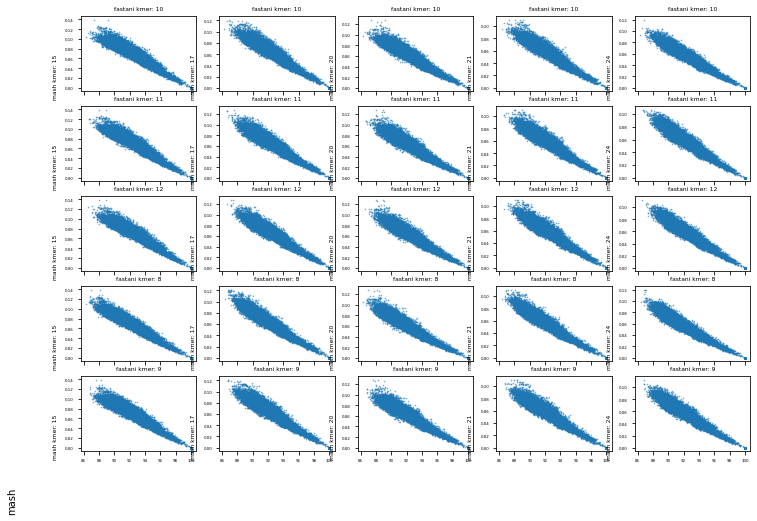

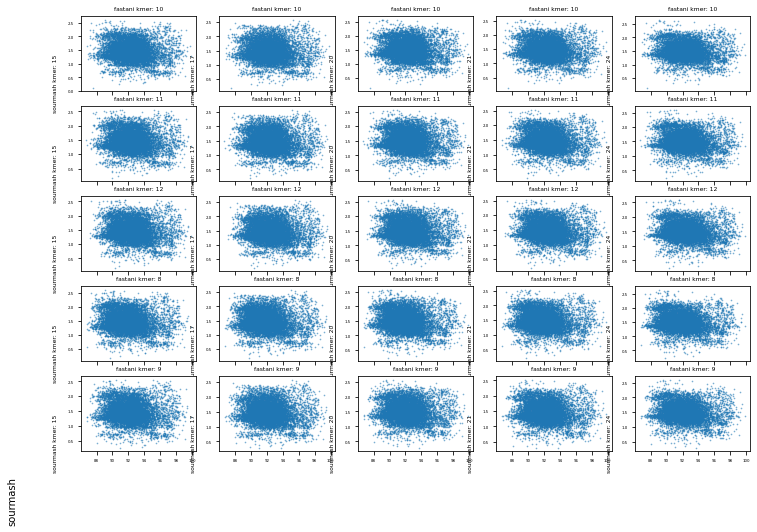

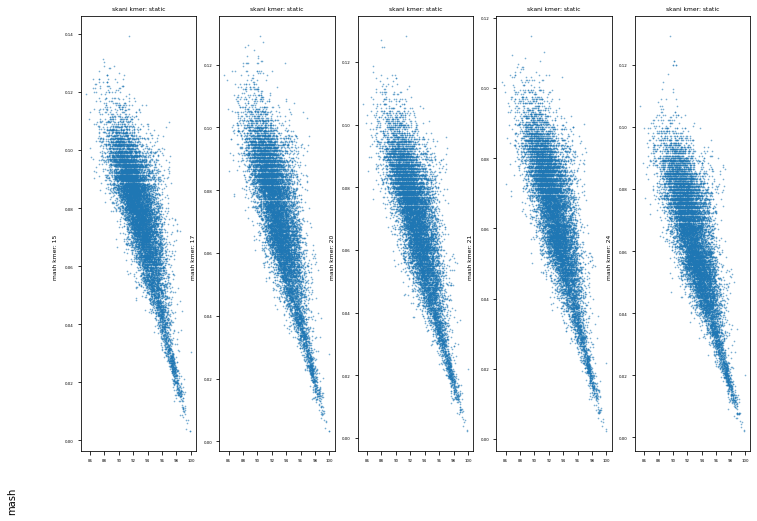

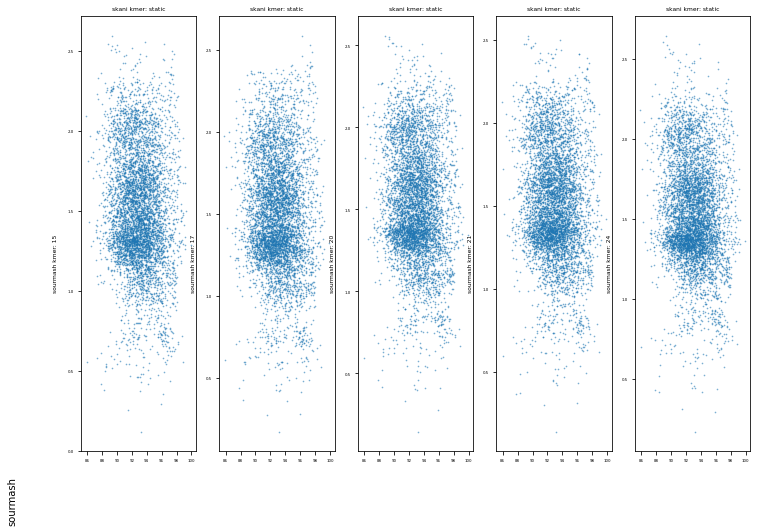

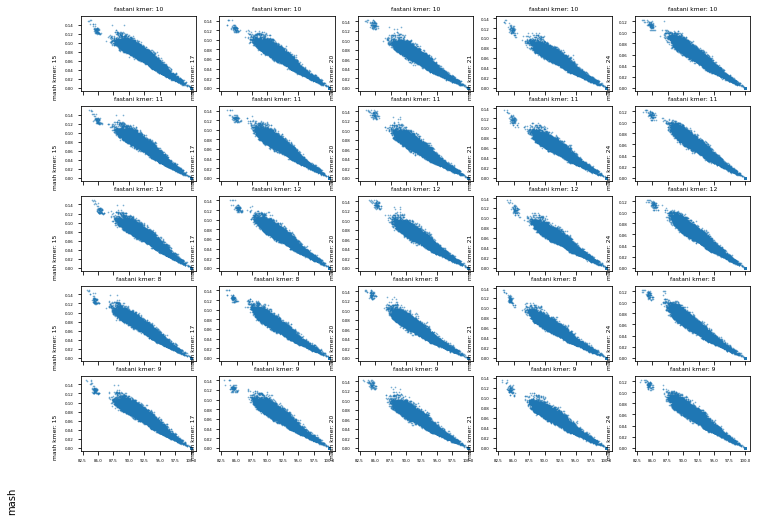

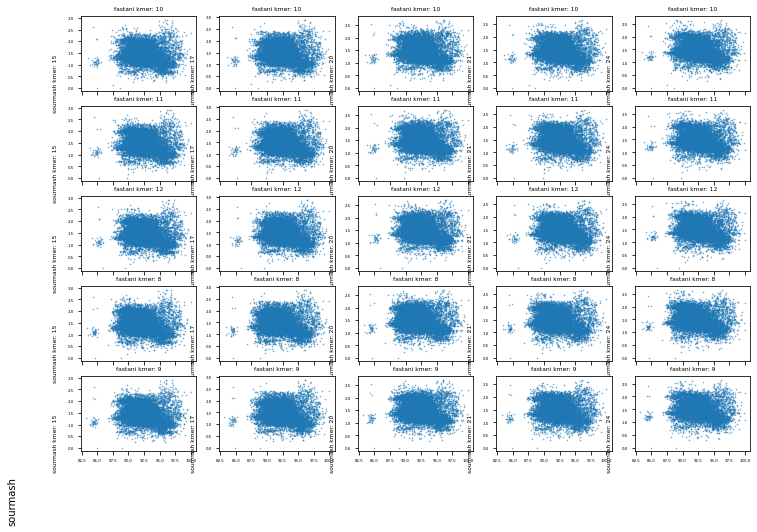

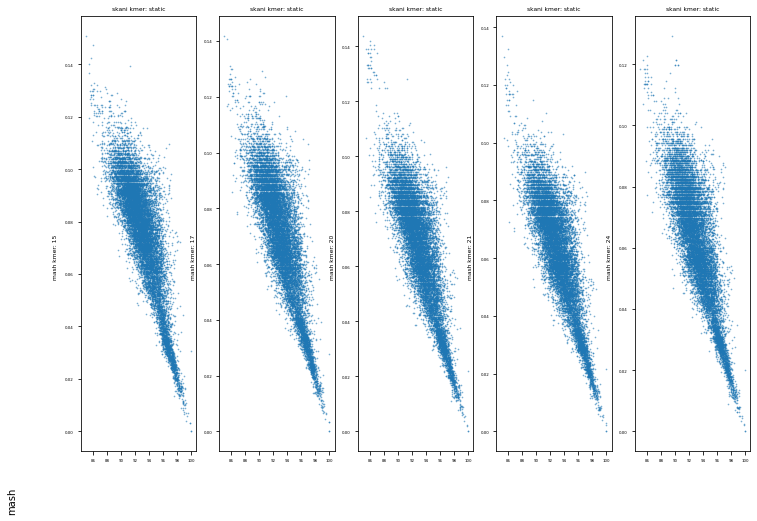

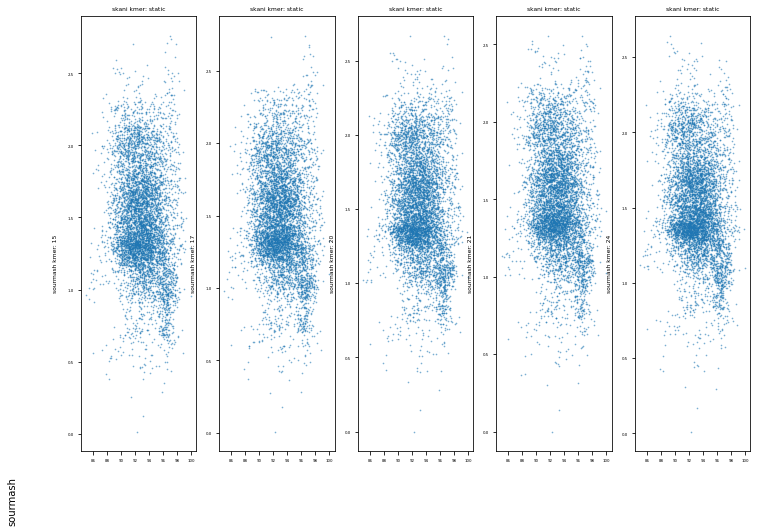

In [19]:
import os
import re
import glob
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Set working directory
workdir = os.path.expanduser("~/phallet/Metrics_Results")
subdirectories = [os.path.join(workdir, name) for name in os.listdir(workdir) if os.path.isdir(os.path.join(workdir, name))]
print(subdirectories)

# Read command-line arguments
args = sys.argv[1:]
mx = "ani"
kmersx = [12, 11, 10, 9, 8]
my = "mash"
kmersy = [15, 17, 20, 21, 24]

# Remove any arguments that are not valid integers
args = [arg for arg in args if re.match(r'^\d+$', arg)]

# Cases for metrics selected on Y
if my == "mash":
    tool_my = ["mash", "sourmash"]
elif my == "ani":
    tool_my = ["fastani", "skani"]
elif my == "aai":
    tool_my = ["comparem"]
elif my == "viridic":
    tool_my = ["viridic"]
elif my == "vcontact2":
    tool_my = ["vcontact2"]
    
if mx == "mash":
    tool_mx = ["mash", "sourmash"]
elif mx == "ani":
    tool_mx = ["fastani", "skani"]
elif mx == "aai":
    tool_mx = ["comparem"]
elif mx == "viridic":
    tool_mx = ["viridic"]
elif mx == "vcontact2":
    tool_mx = ["vcontact2"]

metrics = [mx, my]

ani_data = pd.DataFrame()
mash_data = pd.DataFrame()
viridic_data = pd.DataFrame()
mx_data = pd.DataFrame()
my_data = pd.DataFrame()
df_subset_mx = pd.DataFrame()
df_subset_my = pd.DataFrame()
kmer_values_mx = []
kmer_values_my = []

for m in metrics:
    if m == mx:
        kmers = kmersx
        tool_mx = tool_mx
    if m == my:
        kmers = kmersy
        tool_my = tool_my

for genus in subdirectories:
    os.chdir(genus)
    print(os.getcwd())
    genus_name = os.path.basename(genus)
    genus_dir = os.path.join(workdir, genus_name)
    summaries = glob.glob(os.path.join(genus_dir, "*metrics*.csv"))

    if mx in metrics:
        mx_files = [s for s in summaries if f"{mx}_metrics_" in s]
        if len(mx_files) > 0:
            mx_data = pd.read_csv(mx_files[0])    
        else:
            print(f"No {mx} data for {genus_name}")
    if my in metrics:
        my_files = [s for s in summaries if f"{my}_metrics_" in s]
        if len(my_files) > 0:
            my_data = pd.read_csv(my_files[0])
        else:
            print(f"No {my} data for {genus_name}")
            
# Assuming merged_df is your DataFrame
    for algorithm_mx in tool_mx:
        for algorithm_my in tool_my:
        # Subset the data for the current combination
            if "algorithm" in mx_data.columns:
                df_subset_mx = mx_data[mx_data["algorithm"] == algorithm_mx] 
                kmer_values_mx = sorted(pd.unique(df_subset_mx[f"kmer_{mx}"])) 

            if "algorithm" in my_data.columns:
                df_subset_my = my_data[my_data["algorithm"] == algorithm_my]
                kmer_values_my = sorted(pd.unique(df_subset_my[f"kmer_{my}"]))
   
# Create a scatterplot for each kmer combination
            fig, axes = plt.subplots(len(kmer_values_mx), len(kmer_values_my), figsize=(12,8), sharex=True)
            axes = axes.reshape(len(kmer_values_mx), len(kmer_values_my))
            
            kmer_values_mx.sort()
            kmer_values_my.sort()
# Check if there are any valid combinations of kmer_values_mx and kmer_values_my
            fig.text(0.04, 0.04, algorithm_my, va='center', rotation='vertical')

            for i, mx_kmer in enumerate(kmer_values_mx):
                for j, my_kmer in enumerate(kmer_values_my):
        # Subset the data for the current kmer_mx and kmer_my
                    df_subset_mx_kmer = df_subset_mx[df_subset_mx[f"kmer_{mx}"] == mx_kmer] 
                    df_subset_my_kmer = df_subset_my[df_subset_my[f"kmer_{my}"] == my_kmer]
                    # Check if there are any data points for the current kmer combination
                    merged_df = pd.merge(df_subset_mx_kmer, df_subset_my_kmer, on=["GenomeA", "GenomeB"], how="outer")
                    merged_df.sort_values(by=[f"{mx}_distance",f"{my}_distance"], inplace=True)
        # Create a scatterplot for the current kmer_mx and kmer_my
                    ax = axes[i,j]
                    ax.set_title(f"{algorithm_mx} kmer: {kmer_values_mx[i]}",fontsize=6)
                    ax.tick_params(axis='both', which='major',labelsize=4) 
                    ax.scatter(merged_df[f"{mx}_distance"],merged_df[f"{my}_distance"],alpha=0.5,s=0.5)
                    ax.set_ylabel(f"{algorithm_my} kmer: {kmer_values_my[j]}", rotation=90, ha='right',fontsize=6)
                    ax.yaxis.set_label_coords(-0.2, 0.5) 
                              
        # Save the current figure to a PDF file if there are valid combinations
            pdf_filename = f"{genus_name}_{algorithm_mx}_{algorithm_my}.pdf"
            with PdfPages(pdf_filename) as pdf:
                pdf.savefig(fig)
      